## Neural networks in action

In this tutorial we'll be looking at the building blocks of neural networks and how to implement them in Python with the ```pytorch``` library.


### Content:
- MNIST Dataset 

- Supervised neural networks
    - Neural networks:
        - Single-Layer Feed-Forward NN
        - Multi-Layer Feed-Forward NN
- Unsupervised neural networks
    - Autoencoder
    
- Convolutional neural network (sneak peek)


### Dataset
In this practical, we will work with the hand-written digit classification dataset, [MNIST](http://yann.lecun.com/exdb/mnist/).

![](img/mnist.png)

MNIST ("Modified National Institute of Standards and Technology") is probably one of the most commonly used datsets in computer vision. Since its release in 1999, this classic dataset of handwritten images has served as the basis for benchmarking classification algorithms. 

The dataset consists of 10,000 labelled 28 x 28 pixel images of handwritten digets.

#### Feed-Forward Neural Networks
are artificial neural network wherein connections between the nodes do not form any loops or cycles and -as the name says- feed the information forward.

![](img/nn.png)

#### Single-Layer Feed-Forward NN
The simplest kind of neural network is a single-layer perceptron network, which consists of a single layer of output nodes; the inputs are fed directly to the outputs via a series of weights. 

#### Multi-Layer Feed-Forward NN
A multi-layer neural network contains more than one layer of artificial neurons or nodes. They differ widely in design. It is important to note that while single-layer neural networks were useful early in the evolution of AI, the vast majority of networks used today have a multi-layer model. Multi-layer neural networks can be set up in numerous ways. Typically, they have at least one input layer, which sends weighted inputs to a series of hidden layers, and an output layer at the end.

#### Autoencoder
Autoencoders are an unsupervised learning technique in which we leverage neural networks for the task of representation learning. Specifically, we'll design a neural network architecture such that we impose a bottleneck in the network which forces a compressed knowledge representation of the original input. If the input features were each independent of one another, this compression and subsequent reconstruction would be a very difficult task. However, if some sort of structure exists in the data (ie. correlations between input features), this structure can be learned and consequently leveraged when forcing the input through the network's bottleneck.

![](img/autoen.png)

The picture shows the destinct architecture of an autoencoder that consists of a encoder (left next to bottlenecck) and decoder network (right).

#### Convolutional Neural Network
You'll learn more about CNNs next week, but this tutorial includes a small intro into their architecture. CNN have special layers - convolutional layers - that are great at picking up on patterns in the input image, such as lines, gradients, circles, or even eyes and faces. It is this property that makes CNNs so powerful for computer vision. 



###  Building blocks ('layers') of neural networks

**Input or Visible Layers**
The bottom layer that takes input from your dataset is called the visible layer, because it is the exposed part of the network. Often a neural network is drawn with a visible layer with one neuron per input value or column in your dataset. These are not neurons as described above, but simply pass the input value though to the next layer.

**Hidden Layers**
Layers after the input layer are called hidden layers because that are not directly exposed to the input. The simplest network structure is to have a single neuron in the hidden layer that directly outputs the value.

Given increases in computing power and efficient libraries, very deep neural networks can be constructed. Deep learning can refer to having many hidden layers in your neural network. They are deep because they would have been unimaginably slow to train historically, but may take seconds or minutes to train using modern techniques and hardware.

**Output Layer**
The final hidden layer is called the output layer and it is responsible for outputting a value or vector of values that correspond to the format required for the problem.

The choice of activation function in the output layer is strongly constrained by the type of problem that you are modeling. 



The two mainstream neural network libraries are TensorFlow by Google and PyTorch by Facebook. We will use PyTorch for this practical. Please install the package first, following the instruction. In most cases, you simply need to run the following command on your computer:

```pip3 install torch torchvision```

In [2]:
# Import libaries
import numpy as np
import pandas as pd
import os
import gzip
import struct
import time
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
%matplotlib inline

In [24]:
#Since most of you use laptops, we use CPU for training.
device = 'cpu'
# If some of you would like to try GPU. You can set the device to be CUDA.
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

To load the dataset we will be using a function by the ```torchvision``` library. It automatically downloads the dataset and saves it in the 'data' folder. We further transfer the images into tensors. A ```torch.Tensor``` is a multi-dimensional matrix containing elements of a single data type.

In [7]:
## Loading the dataset
# MNIST dataset (images and labels)
train_dataset = torchvision.datasets.MNIST(root='data', 
                                           train=True, 
                                           transform=transforms.ToTensor(),
                                           download=False) ## you can set this to False, if you already downloaded it

test_dataset = torchvision.datasets.MNIST(root='data', 
                                          train=False, 
                                          transform=transforms.ToTensor(),
                                          download=False)

##### Choosing optimizer and criterion

For this tutorial we'll be using a little upgrade to the 'basic' stochastic gradient descent (SGD), the **Adam** optimizer. While stochastic gradient descent maintains a single learning rate (termed alpha) for all weight updates and the learning rate does not change during training. Adam is an optimization algorithm that can be used instead of the classical stochastic gradient descent procedure to update network weights iteratively based in training data. The Adam optimizer combines the best properties of the AdaGrad and RMSProp algorithms to provide an optimization algorithm that can handle sparse gradients on noisy problems. It is relatively easy to configure while the default configuration parameters do well on most problems.

In practice Adam is currently recommended as the default algorithm to use, and often works slightly better than RMSProp. However, it is often also worth trying SGD+Nesterov Momentum as an alternative.

Criterion: Because this is a multi-class classification problem we'll be using the ```CrossEntropyLoss```. 

More information on choosing a suitable loss function: https://machinelearningmastery.com/loss-and-loss-functions-for-training-deep-learning-neural-networks/


##### Choice of hyper-parameters

- **input size:** This should be the size of the MNIST image (28 * 28)
- **number of classes:** There's 10 different classes in the MNIST dataset
- **number of epochs:** An epoch can is one cycle through the entire training dataset. The number of epoch decides the number of times the weights in the neural network will get updated. The model training should occur on an optimal number of epochs to increase its generalization capacity. There is no fixed number of epochs that will improve your model performance. The number of epochs is actually not that important in comparison to the training and validation loss (i.e. the error). As long as these two losses continue to decrease, the training should continue. In this tutorial we'll keep the number of epochs low for time constraints.
- **batch size:** The batch size is a hyperparameter that defines the number of samples to work through before updating the internal model parameters. In general: Larger batch sizes result in faster progress in training, but don't always converge as fast. Smaller batch sizes train slower, but can converge faster. It's definitely problem and hardware (CPU or GPU) dependent.
- **learning rate:** The amount that the weights are updated during training is referred to as the step size or the “learning rate.” Specifically, the learning rate is a configurable hyperparameter used in the training of neural networks that has a small positive value, often in the range between 0.0 and 1.0. 0.1 is commonly used as default value.

In [20]:
# Hyper-parameters 
input_size = 28 * 28    # 784
num_classes = 10
num_epochs = 5
batch_size = 100
learning_rate = 0.1

In [9]:
# Data loader (input pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

## Dataset

Let's visualise one of the examples of our dataset.

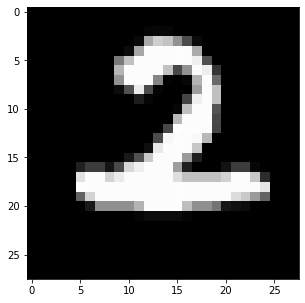

In [10]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# get one image from the batch
img = np.squeeze(images[0])

fig = plt.figure(figsize = (5,5)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')

In [11]:
# obtain the label for the image
labels = labels.numpy()
lab = np.squeeze(labels[0])
lab

2

In this tutorial, we will look at different network architectures and how you can build them yourself. As seen in the last tutorial, networks consist of multiple layers. The simplest layer is probably a linear layer - which is basically a simple logistic regression. A linear layer is defined as ```nn.Linear``` in pytorch. 

### Single-Layer Feed-Forward NN
The simplest kind of neural network is a single-layer perceptron network, which consists of a single layer of output nodes; the inputs are fed directly to the outputs via a series of weights. 

Here we are using a ```nn.Linear``` layer which corresponds to a logistic model.

In [17]:
# Logistic model
lin_model = nn.Linear(input_size, num_classes)

In [18]:
# Loss and optimizer
# nn.CrossEntropyLoss() computes softmax internally
criterion = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

In [21]:
# Train the model
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Reshape images to (batch_size, input_size)
        images = images.reshape(-1, input_size)
        
        # Forward pass
        outputs = lin_model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.reshape(-1, input_size)
        outputs = lin_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()

    print('Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))

# Save the model checkpoint
torch.save(lin_model.state_dict(), 'linear_model.ckpt')

Epoch [1/5], Step [100/600], Loss: 2.3014
Epoch [1/5], Step [200/600], Loss: 2.3090
Epoch [1/5], Step [300/600], Loss: 2.3140
Epoch [1/5], Step [400/600], Loss: 2.2966
Epoch [1/5], Step [500/600], Loss: 2.2859
Epoch [1/5], Step [600/600], Loss: 2.3105
Epoch [2/5], Step [100/600], Loss: 2.3123
Epoch [2/5], Step [200/600], Loss: 2.3440
Epoch [2/5], Step [300/600], Loss: 2.2905
Epoch [2/5], Step [400/600], Loss: 2.3081
Epoch [2/5], Step [500/600], Loss: 2.3128
Epoch [2/5], Step [600/600], Loss: 2.3100
Epoch [3/5], Step [100/600], Loss: 2.2914
Epoch [3/5], Step [200/600], Loss: 2.3184
Epoch [3/5], Step [300/600], Loss: 2.3122
Epoch [3/5], Step [400/600], Loss: 2.3553
Epoch [3/5], Step [500/600], Loss: 2.2841
Epoch [3/5], Step [600/600], Loss: 2.2979
Epoch [4/5], Step [100/600], Loss: 2.3127
Epoch [4/5], Step [200/600], Loss: 2.3464
Epoch [4/5], Step [300/600], Loss: 2.3111
Epoch [4/5], Step [400/600], Loss: 2.3353
Epoch [4/5], Step [500/600], Loss: 2.3148
Epoch [4/5], Step [600/600], Loss:

11% accuracy - We can do better than that!

In [15]:
#Load model (after saving it)
#lin_model.load_state_dict(torch.load('linear_model.ckpt'))
#lin_model.eval()

### Multi-Layer Feed-Forward NN

An multi-layer network consists of at least three layers of nodes: an input layer, a hidden layer and an output layer. Except for the input nodes, each node is a neuron that uses a nonlinear activation function. Its multiple layers and non-linear activation distinguish multi-layer network from a linear perceptron. 


Choice of number of hidden layers: Unfortunately, there is no way to select automatically the number of layers and neurons in each layer. One issue within this subject on which there is a consensus is the performance difference from adding additional hidden layers: the situations in which performance improves with a second (or third, etc.) hidden layer are very few. One hidden layer is sufficient for the large majority of problems.

```hidden_size``` is the number of nodes in one hidden layer. There is a rule of thumb on how to choose the number of nodes in the layer: The number of hidden neurons should be 2/3 the size of the input layer, plus the size of the output layer. The number of hidden neurons should be less than twice the size of the input layer. This hyperparameter can be easily tuned.

In [22]:
# Hyper-parameters 
input_size = 784
hidden_size = 500
num_classes = 10
num_epochs = 5
batch_size = 100
learning_rate = 0.1

In [25]:
# Fully connected neural network with one hidden layer
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size) # 1st Full-Connected Layer: 784 (input data) -> 500 (hidden node)
        self.relu = nn.ReLU() # Non-Linear ReLU Layer: max(0,x)
        self.fc2 = nn.Linear(hidden_size, num_classes)  # 2nd Full-Connected Layer: 500 (hidden node) -> 10 (output class)
    
    def forward(self, x): # Forward pass: stacking each layer together
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

model_nn = NeuralNet(input_size, hidden_size, num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_nn.parameters(), lr=learning_rate)  

In [27]:
model_nn

NeuralNet(
  (fc1): Linear(in_features=784, out_features=500, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [28]:
# Train the model
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):  
        # Move tensors to the configured device
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model_nn(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        outputs = model_nn(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: {} %'.format(100 * correct / total))

# Save the model checkpoint
torch.save(model_nn.state_dict(), 'nn_model.ckpt')

Epoch [1/5], Step [100/600], Loss: 0.5470
Epoch [1/5], Step [200/600], Loss: 0.7052
Epoch [1/5], Step [300/600], Loss: 0.7047
Epoch [1/5], Step [400/600], Loss: 0.8609
Epoch [1/5], Step [500/600], Loss: 0.5021
Epoch [1/5], Step [600/600], Loss: 0.5029
Epoch [2/5], Step [100/600], Loss: 0.4569
Epoch [2/5], Step [200/600], Loss: 0.3818
Epoch [2/5], Step [300/600], Loss: 0.4070
Epoch [2/5], Step [400/600], Loss: 0.4093
Epoch [2/5], Step [500/600], Loss: 0.5039
Epoch [2/5], Step [600/600], Loss: 0.5905
Epoch [3/5], Step [100/600], Loss: 0.3261
Epoch [3/5], Step [200/600], Loss: 0.5587
Epoch [3/5], Step [300/600], Loss: 0.6692
Epoch [3/5], Step [400/600], Loss: 0.6935
Epoch [3/5], Step [500/600], Loss: 0.4774
Epoch [3/5], Step [600/600], Loss: 0.5603
Epoch [4/5], Step [100/600], Loss: 0.9351
Epoch [4/5], Step [200/600], Loss: 0.4546
Epoch [4/5], Step [300/600], Loss: 0.9326
Epoch [4/5], Step [400/600], Loss: 0.3520
Epoch [4/5], Step [500/600], Loss: 0.5906
Epoch [4/5], Step [600/600], Loss:

Hey, 85.91% is a pretty good result for a relatively simple neural network and only 5 training epochs.

In [ ]:
#Load model (after saving it)
#model_nn.load_state_dict(torch.load('nn_model.ckpt'))
#model_nn.eval()

## Autoencoder

An autoencoder is a type of neural network that finds the function mapping the features x to itself. This objective is known as reconstruction, and an autoencoder accomplishes this through the following process: (1) an encoder learns the data representation in lower-dimension space, i.e. extracting the most salient features of the data, and (2) a decoder learns to reconstruct the original data based on the learned representation by the encoder.

The ```encoding_dim``` is the size of the features at the bottleneck of the network. These features are a lot easier to handle and could be potentially used for further analysis.

In [48]:
## very simple autoencoder architecture
class Autoencoder(nn.Module):
    def __init__(self, encoding_dim):
        super(Autoencoder, self).__init__()
        ## encoder ##
        # linear layer (784 -> encoding_dim)
        self.fc1 = nn.Linear(28 * 28, encoding_dim)
        
        ## decoder ##
        # linear layer (encoding_dim -> input size)
        self.fc2 = nn.Linear(encoding_dim, 28*28)
        

    def forward(self, x):
        # add layer, with relu activation function
        x = F.relu(self.fc1(x))
        # output layer (sigmoid for scaling from 0 to 1)
        x = F.sigmoid(self.fc2(x))
        return x

In [49]:
# initialize the NN
encoding_dim = 32
autoencoder = Autoencoder(encoding_dim)
print(autoencoder)

Autoencoder(
  (fc1): Linear(in_features=784, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=784, bias=True)
)


How do we train an autoencoder? How do we know what kind of "encoder" and "decoder" we want?

One observation is that if we pass an image through the encoder, then pass the result through the decoder, we should get roughly the same image back. Ideally, reducing the dimensionality and then generating the image should give us the same result.

This observation provides us a training strategy: we will minimize the reconstruction error of the autoencoder across our training data. We use a loss function called ```MSELoss```, which computes the square error at every pixel.

In [50]:
# specify loss function
criterion = nn.MSELoss()

# specify loss function
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.001)

In [51]:
# number of epochs to train the model
n_epochs = 20

for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    for data in train_loader:
        # _ stands in for labels, here
        images, _ = data
        # flatten images
        images = images.view(images.size(0), -1)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        outputs = autoencoder(images)
        # calculate the loss
        loss = criterion(outputs, images)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*images.size(0)
            
    # print avg training statistics 
    train_loss = train_loss/len(train_loader)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch, 
        train_loss
        ))

Epoch: 1 	Training Loss: 5.619568
Epoch: 2 	Training Loss: 2.895644
Epoch: 3 	Training Loss: 2.301428
Epoch: 4 	Training Loss: 1.919472
Epoch: 5 	Training Loss: 1.737497
Epoch: 6 	Training Loss: 1.669788
Epoch: 7 	Training Loss: 1.638515
Epoch: 8 	Training Loss: 1.586030
Epoch: 9 	Training Loss: 1.531939
Epoch: 10 	Training Loss: 1.521207
Epoch: 11 	Training Loss: 1.513681
Epoch: 12 	Training Loss: 1.508683
Epoch: 13 	Training Loss: 1.504673
Epoch: 14 	Training Loss: 1.501115
Epoch: 15 	Training Loss: 1.498268
Epoch: 16 	Training Loss: 1.495739
Epoch: 17 	Training Loss: 1.493423
Epoch: 18 	Training Loss: 1.491200
Epoch: 19 	Training Loss: 1.489174
Epoch: 20 	Training Loss: 1.487997


Below is the code for plotting some of the test images along with their reconstructions. For the most part these look pretty good except for some blurriness in some parts.

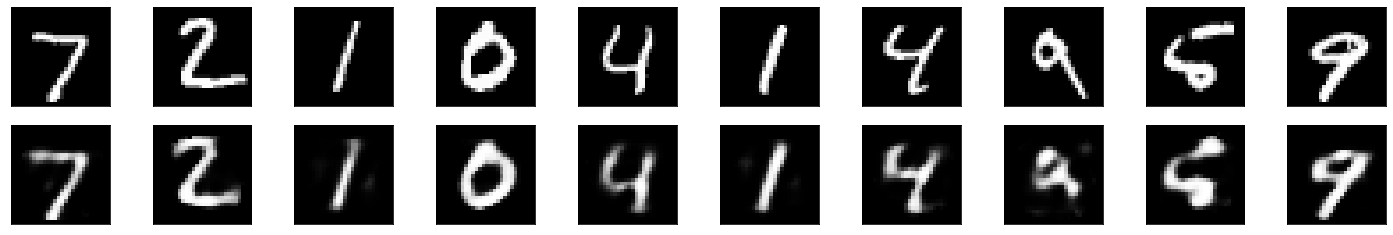

In [52]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

images_flatten = images.view(images.size(0), -1)
# get sample outputs
output = autoencoder(images_flatten)
# prep images for display
images = images.numpy()

# output is resized into a batch of images
output = output.view(batch_size, 1, 28, 28)
# use detach when it's an output that requires_grad
output = output.detach().numpy()

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

# input images on top row, reconstructions on bottom
for images, row in zip([images, output], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

#### EXTRA: Could you create an autoencoder with a more complex architecture (add additional layers)?

## Preview: Convolutional Neural Networks

Regular neural networks receive an input (a single vector), and transform it through a series of hidden layers. Each hidden layer is made up of a set of neurons, where each neuron is fully connected to all neurons in the previous layer, and where neurons in a single layer function completely independently and do not share any connections. The last fully-connected layer is called the “output layer” and in classification settings it represents the class scores.

Regular neural nets don’t scale well to full images. In MNIST, images are only of size 28*28 (28 wide, 28 high, 1 color channels), so a single fully-connected neuron in a first hidden layer of a regular Neural Network would have 28*28 = 784 weights. This amount still seems manageable, but clearly this fully-connected structure does not scale to larger images. For example, an image of more respectable size, e.g. 200x200x3 (3 colour channels), would lead to neurons that have 200*200*3 = 120,000 weights. Moreover, we would almost certainly want to have several such neurons, so the parameters would add up quickly! This full connectivity is difficult for imagery and the huge number of parameters would quickly lead to overfitting.

We'll look at convolutions and CNN-specific layers next week. For this example, we'll use two convolutional layers.

In [34]:
# Convolutional neural network (two convolutional layers)
class ConvNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2), # Convolutional layer
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Linear(7*7*32, num_classes)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

In [35]:
cnn = ConvNet(num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn.parameters(), lr=learning_rate)

In [36]:
# Train the model
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = cnn(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))


Epoch [1/5], Step [100/600], Loss: 0.5370
Epoch [1/5], Step [200/600], Loss: 0.3088
Epoch [1/5], Step [300/600], Loss: 0.1727
Epoch [1/5], Step [400/600], Loss: 0.0889
Epoch [1/5], Step [500/600], Loss: 0.1861
Epoch [1/5], Step [600/600], Loss: 0.1217
Epoch [2/5], Step [100/600], Loss: 0.0804
Epoch [2/5], Step [200/600], Loss: 0.1441
Epoch [2/5], Step [300/600], Loss: 0.1277
Epoch [2/5], Step [400/600], Loss: 0.0987
Epoch [2/5], Step [500/600], Loss: 0.0538
Epoch [2/5], Step [600/600], Loss: 0.1307
Epoch [3/5], Step [100/600], Loss: 0.0840
Epoch [3/5], Step [200/600], Loss: 0.3337
Epoch [3/5], Step [300/600], Loss: 0.0817
Epoch [3/5], Step [400/600], Loss: 0.2264
Epoch [3/5], Step [500/600], Loss: 0.0782
Epoch [3/5], Step [600/600], Loss: 0.1604
Epoch [4/5], Step [100/600], Loss: 0.0415
Epoch [4/5], Step [200/600], Loss: 0.0905
Epoch [4/5], Step [300/600], Loss: 0.0706
Epoch [4/5], Step [400/600], Loss: 0.1633
Epoch [4/5], Step [500/600], Loss: 0.1416
Epoch [4/5], Step [600/600], Loss:

In [38]:
# Test the model
model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = cnn(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))

# Save the model checkpoint
torch.save(cnn.state_dict(), 'cnn_model.ckpt')

Test Accuracy of the model on the 10000 test images: 97.3 %


Wow! The magic of convolutional layers: 97%

In [30]:
#Load model (after saving it)
cnn.load_state_dict(torch.load('cnn_model.ckpt'))
cnn.eval()

ConvNet(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=1568, out_features=10, bias=True)
)

More about CNNs next week!

### References and additional resources:

 - THE deep learning book: https://www.deeplearningbook.org/
 - Pytorch: https://pytorch.org/tutorials/beginner/pytorch_with_examples.html
 - Autoencoder: https://www.jeremyjordan.me/autoencoders/
 - Neural network playground (try different hyperparameters and see what happens): https://developers.google.com/machine-learning/crash-course/introduction-to-neural-networks/playground-exercises
 - CNNs: https://cs231n.github.io/convolutional-networks/